In [929]:
import xmltodict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from datetime import datetime
import json

pd.options.display.max_rows = 99

arquivo_add = str(datetime.now())[-6:]
print(arquivo_add)


991753


# Malha

In [930]:
with open('malha.net.xml', 'rb') as f:
    malha_xml = xmltodict.parse(
        f, attr_prefix='', cdata_key='', dict_constructor=dict)


In [931]:
malha_viaria = []

for attr in malha_xml['net']['edge']:
    try:
        comprimento = attr['lane'][0]['length']
    except:
        comprimento = attr['lane']['length']

    malha_viaria.append([attr['id'], attr['name'], attr['priority'], comprimento,
                         attr['param'][0]['value'], attr['param'][1]['value']])

malha = pd.DataFrame(malha_viaria, columns=[
                     'id', 'name', 'priority', 'length', 'vmax', 'vmin'])

malha.sort_values('priority', inplace=True, ascending=False)
malha[['priority', 'length', 'vmax', 'vmin']] = malha[[
    'priority', 'length', 'vmax', 'vmin']].apply(pd.to_numeric)

malha.head()


,id,name,priority,length,vmax,vmin
21,gneE8,Av.Ver.Abrahão João Francisco,4,33.69,5.94,4.67
20,gneE7,Av.Ver.Abrahão João Francisco,4,20.65,5.94,4.67
6,gneE14,Av.Ver.Abrahão João Francisco,4,26.91,5.94,4.67
7,gneE15,Av.Ver.Abrahão João Francisco,4,34.25,5.94,4.67
16,gneE3,Av.Ver.Abrahão João Francisco,4,20.01,8.50,5.95


# Rotas e demandas

In [932]:
with open('demanda.rou.xml', 'rb') as f:
    dem_xml = xmltodict.parse(
        f, attr_prefix='', cdata_key='', dict_constructor=dict)

# print(json.dumps(dem_xml['routes']['route'], indent=4, ensure_ascii=False))

In [933]:
rotas = pd.DataFrame(dem_xml['routes']['route'])

rotas.drop(columns=['color'], inplace=True)

rotas.head()

,edges,id
0,gneE0 gneE1 gneE2 gneE3 gneE4,route_0
1,gneE0 gneE1 gneE2 gneE3 gneE15 gneE16 gneE17,route_1
2,gneE10 gneE11 gneE12 gneE14 gneE2 gneE24,route_10
3,gneE26 gneE23 gneE15 gneE7 gneE8 gneE9,route_11
4,gneE26 gneE23 gneE15 gneE16 gneE17,route_12


In [934]:
demandas = pd.DataFrame(dem_xml['routes']['flow'])

demandas.head(25)

,id,type,begin,departSpeed,route,end,number
0,flow_0,veic_pass,0.00,8.00,route_0,3600.00,354
1,flow_1,veic_pass,0.00,8.00,route_1,3600.00,354
2,flow_10,veic_pass,0.00,6.00,route_10,3600.00,10
3,flow_11,veic_pass,0.00,6.00,route_11,3600.00,226
4,flow_12,veic_pass,0.00,6.00,route_12,3600.00,226
5,flow_13,veic_pass,0.00,6.00,route_13,3600.00,226
6,flow_14,veic_pass,0.00,6.00,route_14,3600.00,62
7,flow_15,veic_pass,0.00,6.00,route_15,3600.00,62
8,flow_16,veic_pass,0.00,6.00,route_16,3600.00,62
9,flow_3,veic_pass,0.00,8.00,route_3,3600.00,354


In [935]:
demandas.loc[demandas['route'] == 'route_0']['number'].values[0]

'354'

# Resultados da simulação

In [936]:
result_sumo = pd.read_csv('full.output.csv', sep=';')

In [937]:
result_sumo['vehicle_edge'] = result_sumo['vehicle_lane'].str.split(
    '_').str[0]

veics_sumo = result_sumo[result_sumo['vehicle_route'].notnull(
)][['data_timestep', 'vehicle_route', 'vehicle_edge', 'vehicle_speed']]

veic_sumo = veics_sumo.groupby(['vehicle_route', 'vehicle_edge'], as_index=False)[
    'vehicle_speed'].median()

veic_sumo.head()


,vehicle_route,vehicle_edge,vehicle_speed
0,route_0,gneE0,14.80
1,route_0,gneE1,13.12
2,route_0,gneE2,6.87
3,route_0,gneE3,7.81
4,route_0,gneE4,15.05


# Detectores

In [938]:
tree_add = ET.parse('adicionais.xml')
root_add = tree_add.getroot()

b2tf_add = root_add.findall('./e1Detector')

addicional_atual = b2tf_add[0].attrib['file']

with open(addicional_atual, 'rb') as f:
    detect = xmltodict.parse(
        f, attr_prefix='', cdata_key='', dict_constructor=dict)

In [939]:
detec_list = []

for attr in detect['detector']['interval']:
    detec_list.append(
        [attr['id'], float(attr['speed']), int(attr['nVehEntered'])])

detectores = pd.DataFrame(detec_list, columns=[
    'name', 'speed', 'nVehEntered'])

detectores['id'] = detectores['name'].str.split('_').str[1]


In [940]:
detectores_gb = detectores.groupby(['id']).agg({'speed':'mean', 'nVehEntered':'sum'}).reset_index()

In [941]:
detectores_malha = pd.merge(
    detectores_gb, malha, how='left', on=['id']).reset_index()
detectores_malha.head()

,index,id,speed,nVehEntered,name,priority,length,vmax,vmin
0,0,gneE1,12.061563,1062,Av.Ver.Abrahão João Francisco,3,84.08,8.79,4.80
1,1,gneE12,5.808750,30,R.Pres.João Goulart,1,103.05,6.04,3.30
2,2,gneE16,8.201875,1086,R.José Siqueira,3,33.21,11.00,7.70
3,3,gneE21,7.516250,186,R.José Siqueira,3,55.09,7.69,6.05
4,4,gneE23,7.746250,678,R.José Siqueira,2,106.07,6.04,3.30


In [942]:
def comparar_vels(x):
    if x['speed'] > x['vmax']:
        return x['speed'] - x['vmax']
    elif x['speed'] < x['vmin']:
        return x['speed'] - x['vmin']
    else:
        return 0

detectores_malha['dif'] = detectores_malha.apply(comparar_vels, axis=1)


In [943]:
detectores_malha.head(25)

,index,id,speed,nVehEntered,name,priority,length,vmax,vmin,dif
0,0,gneE1,12.061563,1062,Av.Ver.Abrahão João Francisco,3,84.08,8.79,4.80,3.271563
1,1,gneE12,5.808750,30,R.Pres.João Goulart,1,103.05,6.04,3.30,0.000000
2,2,gneE16,8.201875,1086,R.José Siqueira,3,33.21,11.00,7.70,0.000000
3,3,gneE21,7.516250,186,R.José Siqueira,3,55.09,7.69,6.05,0.000000
4,4,gneE23,7.746250,678,R.José Siqueira,2,106.07,6.04,3.30,1.706250
5,5,gneE24,10.263125,918,R.José Siqueira,2,101.76,11.00,7.70,0.000000
6,6,gneE4,11.872188,652,Av.Ver.Abrahão João Francisco,3,582.27,16.00,11.20,0.000000
7,7,gneE6,4.814063,1476,Av.Ver.Abrahão João Francisco,3,136.92,8.79,4.80,0.000000
8,8,gneE9,13.516563,794,Av.Ver.Abrahão João Francisco,3,662.94,16.00,11.20,0.000000


# resultados por rota

In [944]:
rotas_det = {}
detect_edges = set(detectores_malha['id'])

for idx, row in rotas.iterrows():
    rotas_det[row['id']] = {
        'priority': malha.loc[malha['id'] == row['edges'].split()[0]]['priority'].values[0],
        'edge': [],
        'vmax': [],
        'vmin': [],
        'sumo': [],
        'demanda_atrib': None,
        'sumo_sensor_speed1': None,
        'sumo_sensor_speed2': None,
        'vmax_sensor1': None,
        'vmax_sensor2': None,
        'vmin_sensor1': None,
        'vmin_sensor2': None,
        'sensor_edge1': None,
        'sensor_edge1_priority': None,
        'sensor_edge1_length': None,
        'sensor_edge2': None,
        'sensor_edge2_priority': None,
        'sensor_edge2_length': None,
        'sensor_speed1': None,
        'sensor_speed2': None,
        'sensor_veic1':  None,
        'sensor_veic2':  None,
        'demand_num': None
    }

    demanda_xml = int(
        demandas.loc[demandas['route'] == row['id']]['number'].values[0])
    # print(demanda_xml)

    rotas_det[row['id']]['demanda_atrib'] = demanda_xml
    rotas_det[row['id']]['demand_num'] = demanda_xml

    for edge in row['edges'].split():
        rotas_det[row['id']]['edge'].append(edge)
        vmax = malha[malha['id'] == edge]['vmax'].values[0]
        rotas_det[row['id']]['vmax'].append(vmax)
        vmin = malha[malha['id'] == edge]['vmin'].values[0]
        rotas_det[row['id']]['vmin'].append(vmin)
        speed_sumo = veic_sumo[veic_sumo['vehicle_edge']
                               == edge]['vehicle_speed'].values[0]
        rotas_det[row['id']]['sumo'].append(speed_sumo)

        if edge in detect_edges:
            detector_edge = detectores_malha[detectores_malha['id']
                                             == edge]['id'].values[0]

            if edge == detector_edge and rotas_det[row['id']]['sensor_edge1'] == None:
                rotas_det[row['id']]['sensor_speed1'] = detectores_malha[detectores_malha['id']
                                                                         == edge]['speed'].values[0]
                rotas_det[row['id']]['sensor_veic1'] = detectores_malha[detectores_malha['id']
                                                                        == edge]['nVehEntered'].values[0]
                rotas_det[row['id']]['sensor_edge1'] = detector_edge
                rotas_det[row['id']]['sensor_edge1_priority'] = malha[malha['id']
                                                                      == edge]['priority'].values[0]
                rotas_det[row['id']]['sensor_edge1_length'] = malha[malha['id']
                                                                    == edge]['length'].values[0]
                rotas_det[row['id']]['sumo_sensor_speed1'] = speed_sumo
                rotas_det[row['id']]['vmax_sensor1'] = vmax
                rotas_det[row['id']]['vmin_sensor1'] = vmin

            elif edge == detector_edge:
                rotas_det[row['id']]['sensor_speed2'] = detectores_malha[detectores_malha['id']
                                                                         == edge]['speed'].values[0]
                rotas_det[row['id']]['sensor_veic2'] = detectores_malha[detectores_malha['id']
                                                                        == edge]['nVehEntered'].values[0]
                rotas_det[row['id']]['sensor_edge2_priority'] = malha[malha['id']
                                                                      == edge]['priority'].values[0]
                rotas_det[row['id']]['sendor_edge2'] = edge

                rotas_det[row['id']]['sensor_edge2_length'] = malha[malha['id']
                                                                    == edge]['length'].values[0]

                rotas_det[row['id']]['sumo_sensor_speed2'] = speed_sumo
                rotas_det[row['id']]['vmax_sensor2'] = vmax
                rotas_det[row['id']]['vmin_sensor2'] = vmin


In [945]:
rotas_det.keys()

dict_keys(['route_0', 'route_1', 'route_10', 'route_11', 'route_12', 'route_13', 'route_14', 'route_15', 'route_16', 'route_3', 'route_4', 'route_5', 'route_7', 'route_8', 'route_9'])

In [946]:
rotas_det['route_4']

{'priority': 3,
 'edge': ['gneE5', 'gneE6', 'gneE7', 'gneE8', 'gneE9'],
 'vmax': [16.0, 8.79, 5.94, 5.94, 16.0],
 'vmin': [11.2, 4.8, 4.67, 4.67, 11.2],
 'sumo': [0.96, 0.9, 7.655, 7.8149999999999995, 15.02],
 'demanda_atrib': 492,
 'sumo_sensor_speed1': 0.9,
 'sumo_sensor_speed2': 15.02,
 'vmax_sensor1': 8.79,
 'vmax_sensor2': 16.0,
 'vmin_sensor1': 4.8,
 'vmin_sensor2': 11.2,
 'sensor_edge1': 'gneE6',
 'sensor_edge1_priority': 3,
 'sensor_edge1_length': 136.92,
 'sensor_edge2': None,
 'sensor_edge2_priority': 3,
 'sensor_edge2_length': 662.94,
 'sensor_speed1': 4.8140625,
 'sensor_speed2': 13.516562500000001,
 'sensor_veic1': 1476,
 'sensor_veic2': 794,
 'demand_num': 492,
 'sendor_edge2': 'gneE9'}

## Gráfico com a progressão da rota na simulação / velocidade máxima e mínima esperada.

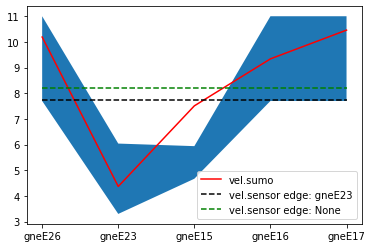

In [947]:
rota_plot = pd.DataFrame.from_dict(rotas_det['route_12'])
rota_plot_label1 = f"vel.sensor edge: {rota_plot['sensor_edge1'].values[0]}"
rota_plot_label2 = f"vel.sensor edge: {rota_plot['sensor_edge2'].values[0]}"
col = rota_plot.loc[:, 'vmax':'vmin']
plt.plot('edge', 'sumo', label='vel.sumo', c='red', data=rota_plot)
plt.plot('edge', 'sensor_speed1', label=rota_plot_label1,
         c='black', linestyle="--", data=rota_plot)
plt.plot('edge', 'sensor_speed2', label=rota_plot_label2,
         c='green', linestyle="--", data=rota_plot)
plt.fill_between(x='edge', y1='vmin', y2='vmax', data=rota_plot)
plt.legend()
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

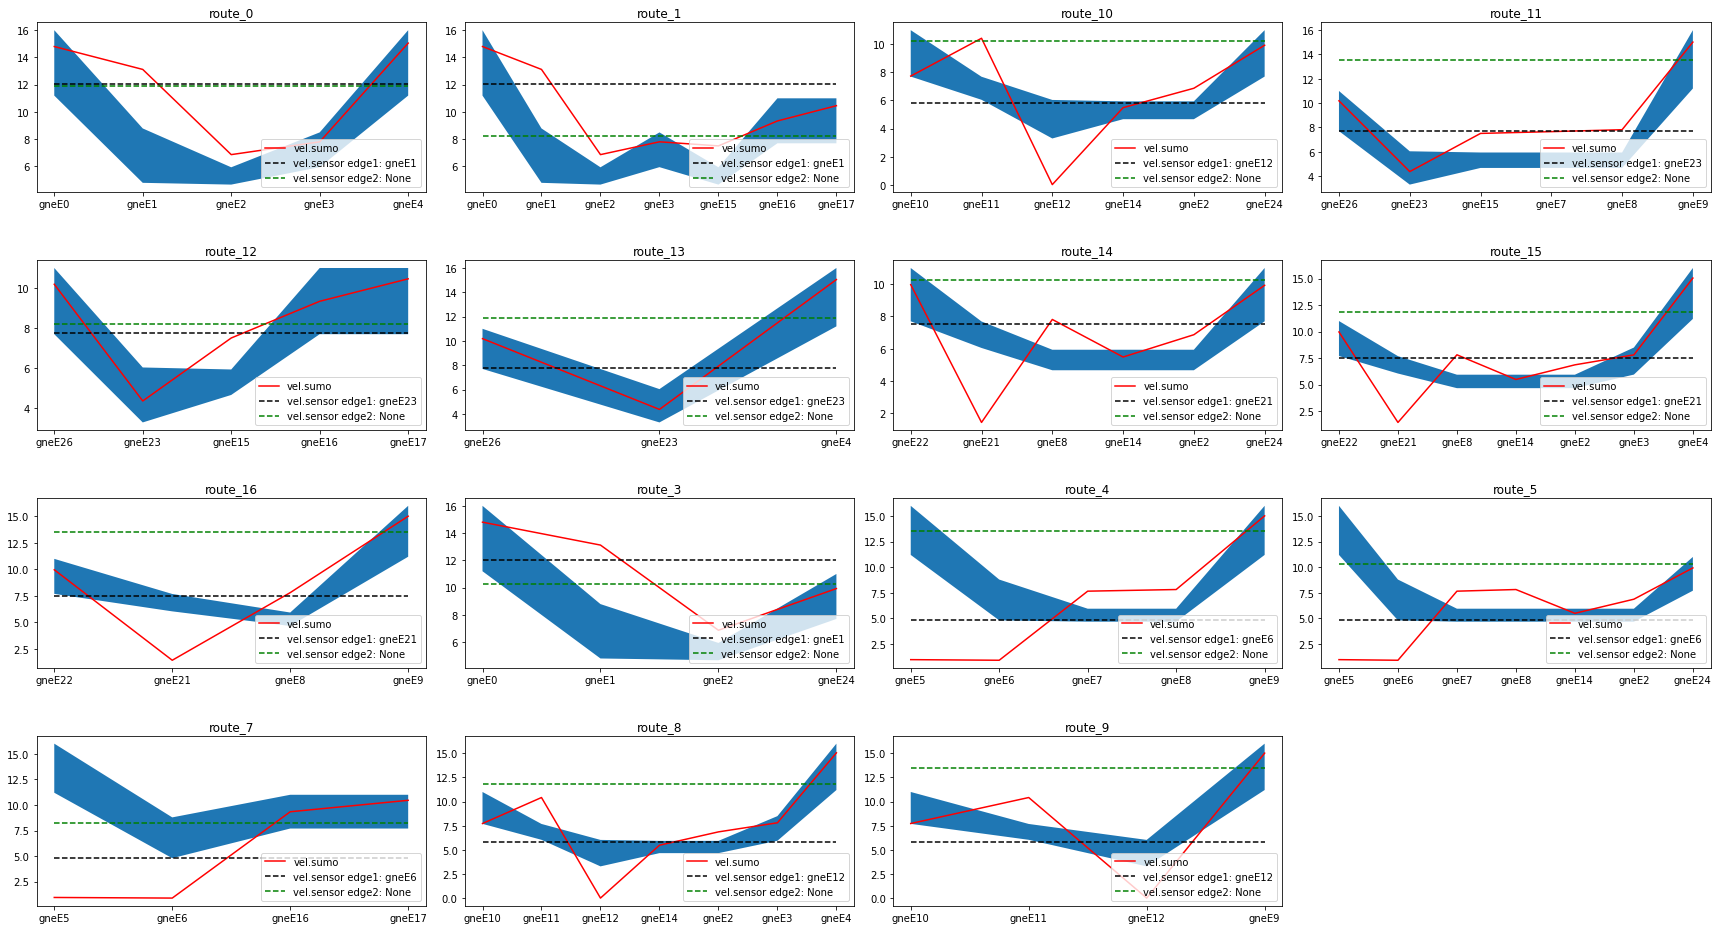

In [948]:
fig = plt.figure(figsize=(30, 25))
fig.subplots_adjust(hspace=.4, wspace=.1)

for idx, rota in enumerate(rotas_det.keys()):
    rota_plot = pd.DataFrame.from_dict(rotas_det[rota])
    rota_plot_label1 = f"vel.sensor edge1: {rota_plot['sensor_edge1'].values[0]}"
    rota_plot_label2 = f"vel.sensor edge2: {rota_plot['sensor_edge2'].values[0]}"
    fig.add_subplot(6, 4, idx+1)
    plt.plot('edge', 'sumo', label='vel.sumo', c='red', data=rota_plot)
    plt.plot('edge', 'sensor_speed1', label=rota_plot_label1,
             c='black', linestyle="--", data=rota_plot)
    plt.plot('edge', 'sensor_speed2', label=rota_plot_label2,
             c='green', linestyle="--", data=rota_plot)
    plt.fill_between(x='edge', y1='vmin', y2='vmax', data=rota_plot)
    plt.legend(loc=4)
    plt.title(rota)

plt.savefig(f'resultados/plots/{arquivo_add}.png')
plt.show


## novos valores rota, prioridade 4 (máxima encontrada no início de uma rota)

Alterações no número de veículos próxima simulação

In [949]:
malha['priority'].unique()

array([4, 3, 2, 1])

In [950]:
for chave, valor in rotas_det.items():
    sumo_sensor_speed1 = valor['sumo_sensor_speed1']
    vmax_sensor1 = valor['vmax_sensor1']
    sumo_sensor_speed2 = valor['sumo_sensor_speed2']
    vmax_sensor2 = valor['vmax_sensor2']
    demanda_atrib = valor['demanda_atrib']
    print(
        f'route:{chave}, prioridade:{valor["priority"]}, sumo_sensor_speed1:{sumo_sensor_speed1}, vmax_sensor1:{vmax_sensor1}')

#    if valor['priority'] == 3 and sumo_sensor_speed1 > vmax_sensor1:
#        rotas_det[chave]['demand_num'] = np.ceil(demanda_atrib +
#                                                 (((abs(valor['sumo_sensor_speed1'] - valor['vmax_sensor1'])) * valor['sensor_edge1_length'])/20))
#        print(
#            f'prioridade3: {demanda_atrib} -> {rotas_det[chave]["demand_num"]}')

    if valor['priority'] == 2 and sumo_sensor_speed1 > vmax_sensor1:
        rotas_det[chave]['demand_num'] = np.ceil(demanda_atrib +
                                                 (((abs(valor['sumo_sensor_speed1'] - valor['vmax_sensor1'])) * valor['sensor_edge1_length'])/20))
        print(
            f'prioridade2: {demanda_atrib} -> {rotas_det[chave]["demand_num"]}')

    if valor['priority'] == 1 and sumo_sensor_speed1 > vmax_sensor1:
        rotas_det[chave]['demand_num'] = np.ceil(demanda_atrib +
                                                 (((abs(valor['sumo_sensor_speed1'] - valor['vmax_sensor1'])) * valor['sensor_edge1_length'])/20))
        print(
            f'prioridade1: {demanda_atrib} -> {rotas_det[chave]["demand_num"]}')


route:route_0, prioridade:3, sumo_sensor_speed1:13.12, vmax_sensor1:8.79
route:route_1, prioridade:3, sumo_sensor_speed1:13.12, vmax_sensor1:8.79
route:route_10, prioridade:1, sumo_sensor_speed1:0.02, vmax_sensor1:6.04
route:route_11, prioridade:2, sumo_sensor_speed1:4.37, vmax_sensor1:6.04
route:route_12, prioridade:2, sumo_sensor_speed1:4.37, vmax_sensor1:6.04
route:route_13, prioridade:2, sumo_sensor_speed1:4.37, vmax_sensor1:6.04
route:route_14, prioridade:3, sumo_sensor_speed1:1.44, vmax_sensor1:7.69
route:route_15, prioridade:3, sumo_sensor_speed1:1.44, vmax_sensor1:7.69
route:route_16, prioridade:3, sumo_sensor_speed1:1.44, vmax_sensor1:7.69
route:route_3, prioridade:3, sumo_sensor_speed1:13.12, vmax_sensor1:8.79
route:route_4, prioridade:3, sumo_sensor_speed1:0.9, vmax_sensor1:8.79
route:route_5, prioridade:3, sumo_sensor_speed1:0.9, vmax_sensor1:8.79
route:route_7, prioridade:3, sumo_sensor_speed1:0.9, vmax_sensor1:8.79
route:route_8, prioridade:1, sumo_sensor_speed1:0.02, vma

## Salvando arquivos

In [951]:
# rotas
df_export = pd.DataFrame(rotas_det)

df_export.to_json(path_or_buf=f'resultados/rotas/{arquivo_add}.json')


In [952]:
# sensores
for ln in b2tf_add:
    ln.attrib['file'] = f'resultados/detectores/{arquivo_add}.xml'

tree_add.write("adicionais.xml")

In [953]:
#demandas
tree = ET.parse('demanda.rou.xml')
root = tree.getroot()

In [954]:
# localizar uma rota

#b2tf = root.find("./flow[@id='flow_6']")
#print(b2tf.attrib)
#b2tf.attrib['number'] = '100'
#print(b2tf.attrib)

In [955]:
br = []
centro = []
ressacada = []
dombosco = []

for rota in rotas_det:
    b2tf = root.find(f'./flow[@route="{rota}"]')
    if rota in ('route_0', 'route_1', 'route_3'):
        br.append(int(rotas_det[rota]['demand_num']))
    if rota in ('route_4', 'route_5', 'route_7'):
        centro.append(int(rotas_det[rota]['demand_num']))
    if rota in ('route_11', 'route_12', 'route_13'):
        ressacada.append(int(rotas_det[rota]['demand_num']))
    if rota in ('route_14', 'route_15', 'route_16','route_8', 'route_9', 'route_10'):
        dombosco.append(int(rotas_det[rota]['demand_num']))
    b2tf.attrib['number'] = str(int(rotas_det[rota]['demand_num']))
    print(b2tf.attrib)


{'id': 'flow_0', 'type': 'veic_pass', 'begin': '0.00', 'departSpeed': '8.00', 'route': 'route_0', 'end': '3600.00', 'number': '354'}
{'id': 'flow_1', 'type': 'veic_pass', 'begin': '0.00', 'departSpeed': '8.00', 'route': 'route_1', 'end': '3600.00', 'number': '354'}
{'id': 'flow_10', 'type': 'veic_pass', 'begin': '0.00', 'departSpeed': '6.00', 'route': 'route_10', 'end': '3600.00', 'number': '10'}
{'id': 'flow_11', 'type': 'veic_pass', 'begin': '0.00', 'departSpeed': '6.00', 'route': 'route_11', 'end': '3600.00', 'number': '226'}
{'id': 'flow_12', 'type': 'veic_pass', 'begin': '0.00', 'departSpeed': '6.00', 'route': 'route_12', 'end': '3600.00', 'number': '226'}
{'id': 'flow_13', 'type': 'veic_pass', 'begin': '0.00', 'departSpeed': '6.00', 'route': 'route_13', 'end': '3600.00', 'number': '226'}
{'id': 'flow_14', 'type': 'veic_pass', 'begin': '0.00', 'departSpeed': '6.00', 'route': 'route_14', 'end': '3600.00', 'number': '62'}
{'id': 'flow_15', 'type': 'veic_pass', 'begin': '0.00', 'depa

In [956]:
detectores_malha.head()

,index,id,speed,nVehEntered,name,priority,length,vmax,vmin,dif
0,0,gneE1,12.061563,1062,Av.Ver.Abrahão João Francisco,3,84.08,8.79,4.80,3.271563
1,1,gneE12,5.808750,30,R.Pres.João Goulart,1,103.05,6.04,3.30,0.000000
2,2,gneE16,8.201875,1086,R.José Siqueira,3,33.21,11.00,7.70,0.000000
3,3,gneE21,7.516250,186,R.José Siqueira,3,55.09,7.69,6.05,0.000000
4,4,gneE23,7.746250,678,R.José Siqueira,2,106.07,6.04,3.30,1.706250


In [957]:
print(f'centro:{sum(centro)}\nbr:{sum(br)}\n\
ressacada:{sum(ressacada)}\ndom bosco:{sum(dombosco)}')


centro:1476
br:1062
ressacada:678
dom bosco:216


In [958]:
tree.write("demanda.rou.xml")
tree.write(f'resultados/demandas/{arquivo_add}.rou.xml')

## rodar próx.passo

In [959]:
# rodar simulação
!sumo simulacao.sumocfg


Loading configuration ... done.



In [960]:
# to csv
!python3 xml2csv.py full.output.xml
!rm full.output.xml
